In [33]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn as sns
sns.set()
from IPython.display import HTML

In [3]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "red", "yellow"])

In [38]:
class SigmoidNeuron:
    
    def __init__(self, w_init, b_init, algo):
        self.w = w_init
        self.b = b_init
        self.w_h = []
        self.b_h = []
        self.e_h = []
        self.algo = algo
        
    def sigmoid(self, X, w = None, b = None):
        if w is None:
            w = self.w
        if b is None:
            b = self.b
            
        return 1. / (1. + np.exp(-(w*X + b)))    
            
    def error(self, X, Y, w = None, b = None):
        if w is None:
            w = self.w
        if b is None:
            b = self.b
            
        err = 0
        for x, y in zip(X, Y):
            err += 0.5 * (self.sigmoid(x, w, b) - y) ** 2
        return err
    
    def grad_w(self, x, y, w= None, b=None):
        if w is None:
            w = self.w
        if b is None:
            b = self.b
        y_pred = self.sigmoid(x, w, b)
        return (y_pred - y) * y_pred * (1 - y_pred) * x
    
    
    def grad_b(self, x, y, w= None, b=None):
        if w is None:
            w = self.w
            
        if b is None:
            b = self.b
            
        y_pred = self.sigmoid(x, w, b)
        return (y_pred -y) * y_pred * (1 - y_pred)
    
    def fit(self, X, Y, epochs= 100, eta = 0.01, gamma = 0.9,
            mini_batch_size= 100, eps=1e-8, beta = 0.9, beta1 = 0.9,
            beta2 = 0.9
           ):
        self.w_h = []
        self.b_h = []
        self.e_h = []
        self.X = X
        self.Y = Y
        
        if self.algo == "GD":
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                self.w -= eta * dw / X.shape[0]
                self.b -= eta * db / X.shape[0]
                self.append_log()
                
        elif self.algo == "Momentum":
            v_w_prev, v_b_prev = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                v_w = gamma * v_w_prev + eta * dw
                v_b = gamma * v_b_prev + eta * db
                self.w = self.w - v_w
                self.b = self.b - v_b
                v_w_prev = v_w
                v_b_pev = v_b
                self.append_log()
            
        elif self.algo == "NAG":
            v_w_prev, v_b_prev = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                v_w = gamma * v_w_prev
                v_b = gamma * v_b_prev
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y, self.w - v_w, self.b - v_b)
                    db += self.grad_b(x, y, self.w - v_w, self.b - v_b)
                v_w = gamma * v_w_prev + eta * dw
                v_b = gamma * v_b_prev + eta * db
                self.w = self.w - v_w
                self.b = self.b - v_b
                v_w_prev = v_w
                v_b_prev = v_b
                self.append_log()

            
        elif self.algo == 'MiniBatch':
            for i in range(epochs):
                dw, db = 0, 0
                points_seen = 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                    points_seen += 1
                    if points_seen % mini_batch_size  == 0:
                        self.w -= eta * dw / mini_batch_size
                        self.b -= eta * db / mini_batch_size
                        self.append_log()
                        dw, db = 0, 0
        
        
        elif self.algo == 'AdaGrad':
            v_w, v_b = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                v_w += dw ** 2
                v_b += db ** 2
                self.w -= (eta / np.sqrt(v_w) + eps) * dw
                self.b -= (eta / np.sqrt(v_b) + eps) * db
                self.append_log()
            
        elif self.algo == 'RMSProp':
            v_w, v_b = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                v_w = beta * v_w + (1 - beta) * dw ** 2
                v_b = beta * v_b + (1 - beta) * db ** 2
                self.w -= (eta / np.sqrt(v_w) + eps) * dw
                self.b -= (eta / np.sqrt(v_b) + eps) * db
                self.append_log()
                
                
        
        elif self.algo == "Adam":
            v_w, v_b = 0, 0
            m_w, m_b = 0, 0
            num_updates = 0
            for i in range(epochs):
                dw, db = 0
                for x, y in zip(X, Y):
                    dw = self.grad_w(x, y)
                    db = self.grad_b(x, y)
                    num_updates += 1
                    m_w = beta1 * m_w + (1 - beta1) * dw
                    m_b = beta2 * m_b + (1 - beta1) * db
                    v_w = beta2 * v_w + (1 - beta2) * dw**2
                    v_b = beta2 * v_w + (1 - beta2) * db**2
                    m_w_c = m_w / (1 - np.power(beta1, num_updates))
                    m_b_c = m_b / (1 - np.power(beta1, num_updates))
                    v_w_c = v_w / (1 - np.power(beta2, num_updates))
                    v_b_c = v_b / (1 - np.power(beta2, num_updates))
                    self.w -= (eta / np.sqrt(v_w_c) + eps) * m_w_x
                    self.b -= (eta / np.sqrt(v_b_c) + eps) * m_b_c
                    self.append_log()
                    
    
    def append_log(self):
        self.w_h.append(self.w)
        self.b_h.append(self.b)
        self.e_h.append(self.error(self.X, self.Y))
        
            

### Gradient Descent

In [50]:
X = np.array([0.5, 2.4])
Y = np.array([0.2, 0.9])

algo = "GD"

w_init = -2
b_init = -2

epochs = 1000
eta = 0.5

w_min = -7
w_max = 5

b_min = -5
b_max = 5

plot_3d = True

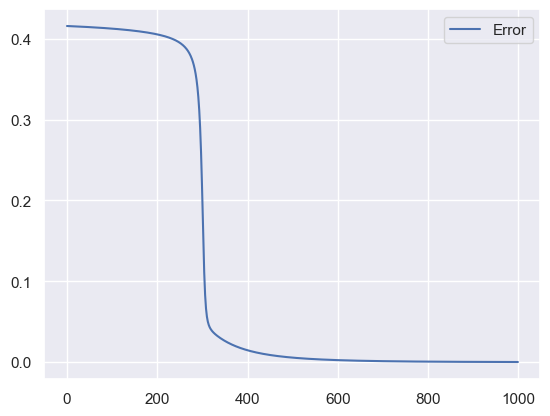

In [51]:
sn = SigmoidNeuron(w_init, b_init, algo)
sn.fit(X, Y, epochs = epochs, eta = eta)
plt.plot(sn.e_h, label = "Error")
plt.legend()
plt.show()

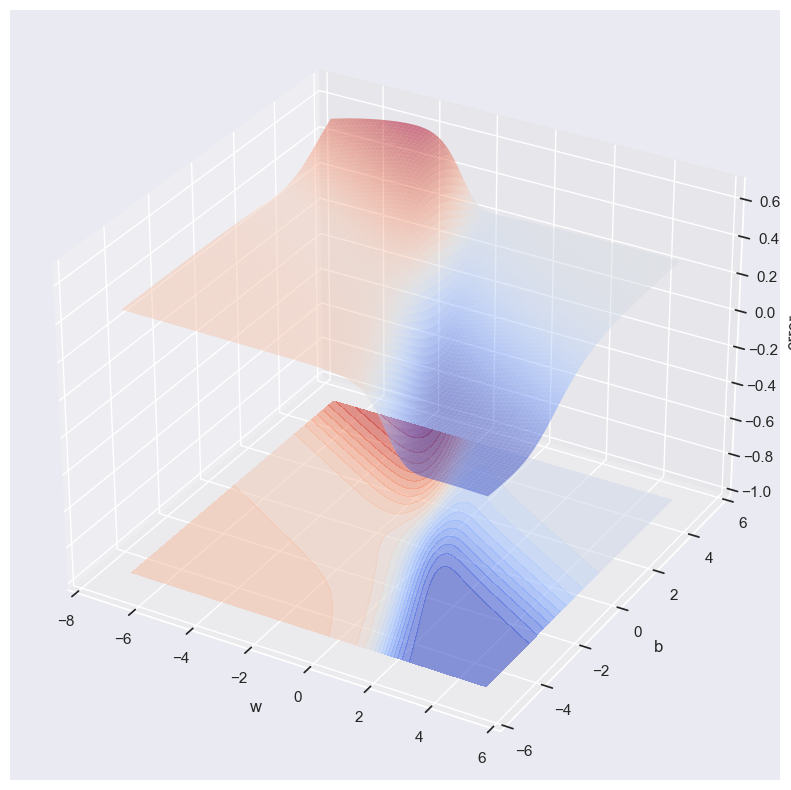

In [52]:
if plot_3d:
    W = np.linspace(w_min, w_max, 256)
    b = np.linspace(b_min, b_max, 256)
    WW, BB = np.meshgrid(W, b)
    Z = sn.error(X, Y, WW, BB)

    fig = plt.figure(dpi= 100, figsize= (20, 10))
    ax = fig.add_subplot(projection = '3d')
    surf = ax.plot_surface(WW, BB, Z, rstride= 3, cstride = 3, alpha = 0.5, cmap = cm.coolwarm, linewidth = 0)
    cset = ax.contourf(WW, BB, Z, 25, zdir  = 'z', offset = -1, alpha = 0.6, cmap = cm.coolwarm)
    ax.set_xlabel('w')
    ax.set_xlim(w_min -1 , w_max + 1)
    ax.set_ylabel('b')
    ax.set_ylim(b_min -1 , b_max + 1)
    ax.set_zlabel('error')
    ax.set_zlim(-1, np.max(Z));